# OCNG/ATMO 651 Final Project: Linear Inverse Model of Tropical Sea Surface Temperatures

## Dataset
NCEP/NCAR Reanalysis monthly-mean SST from 1948-01 to 2017-09. The dataset are divided into two parts: the training set and the test set. The training set contains 1948-01 to 1999-12, and the test set contains 2000-01 to 2017-09.

## Steps

1. Smooth SST anomalies (SSTAs) using a 3-month running mean and then perform an EOF analysis on the smoothed SSTAs;
2. Reconstruct and truncate SSTAs using leading EOFs and the corresponding principal component time series as, $T(t)=\sum _{i=1}^M P_(t) E_i$, where $E_i$ is the $i$-th EOF, $P_i(t)$ is the $i$-th principal component, $M$ is the number of EOFs used to represent $T(t)$. Typically, $M$ is less than 10 and can be determined by the explained variance, say 90%, by the first $M$ EOFs;
3. Compute covariance and lag-covariance matrix in EOF space, $ \check{C} = \overline{P(t)P'(t)}$, $\check{C}_{\Delta t} = \overline{P(t+\Delta t)P'(t)} $ (overline stands for time average), where $\check{C}$ and $\check{C}_{\Delta t}$ are the covariance and lag-covariance matrix in EOF space, $P(t)_{M\times 1}$ is a state vector of $P_i(t)$ and $P'(t)$ is its transpose, i.e., $P'(t) = [P_1(t), P_2(t), …, P_M(t)]_{1\times M}$;
4. Compute the propagator in EOF space, $G=\check{C}_{\Delta t} \check{C}^{-1}$, where the lag $\Delta t$ can be taken to be 7 months (see Penland and Magorian (1993)) and $G$ has $M\times M$ dimension;
5. Take an initial SSTA state vector $T$ at any $t_0$, regress $T(t_0)$ onto $E_i$ to determine $P_i(t_0)$ and then form $P(t_0)$;
6. Make SST forecast in EOF space from $t_0$ to $t_n$: $P(t_n) = G^{\frac{t_n-t_0}{\Delta t}}P(t_0)$;
7. Transform the forecast in EOF space, $P(t_n)$, back to the physical space: $T(t_n)=\sum _{i=1}^M P(t_n) E_i$.


### 1. Smooth SSTAs

Smooth SST anomalies (SSTAs) using a 3-month running mean.

In [14]:
import numpy.linalg as la
import xarray as xr
import numpy as np
from rich import print

def get_anomaly(x):
    """Remove the seasonal cycle from the data.
    Params: x (numpy array): data with time dimension
    Returns: x (numpy array): data with seasonal cycle removed
    """
    nt, ny, nx = x.shape
    # if nt is not a multiple of 12, remove the last few months
    if nt % 12 != 0:
        x = x[:-(nt % 12),:,:]
    nt, ny, nx = x.shape
    x = x.reshape(nt//12, 12, ny, nx)
    # seasonal mean
    x_mean = x.mean(axis=0, keepdims=True)
    # remove seasonal cycle
    x = x - x_mean
    # reshape time dimension
    x = x.reshape(nt, ny, nx)
    return x

def running_mean(x, m):
    """Compute the running mean of x along the first dimension.
    Params: x (numpy array): data
            m (int): half of the window size
    Returns: x (numpy array): data with running mean
    """
    # reference:
    # https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
    nt, ny, nx = x.shape
    x_rm = np.zeros_like(x)
    # pad the data along the dimension dim with m elements
    pad_width = [(0, 0)]*x.ndim
    pad_width[0] = (m, m)
    x = np.pad(x, pad_width, mode='edge')
    # compute the running mean
    for j in range(ny):
        for i in range(nx):
            x_rm[:,j,i] = np.convolve(x[:,j,i], np.ones(2*m+1)/float(2*m+1), mode='valid')
    return x_rm

# read in the data
dir = "../NCEP_monthly_mean_data/"
sst_ds = xr.open_dataset(dir + "skt.sfc.mon.mean.tropics.nc", use_cftime=True)
grid_ds = xr.open_dataset(dir + "lsmask.tropics.nc", use_cftime=True)
# get the data
sst_da, grid_da = sst_ds.skt, grid_ds.lsmask
# reverse the latitude dimension to make it increasing
sst_da = sst_da.reindex(lat=sst_da.lat[::-1])
grid_da = grid_da.reindex(lat=grid_da.lat[::-1])
# select data from 1948 to 1999 for training, 
# and in a target region (30N-30S, 100E-60W)
lat_min, lat_max = -30, 30
lon_min, lon_max = 100, 300
sst = sst_da.sel(time=slice("1948", "1999"), lon=slice(lon_min, lon_max))
grid = grid_da.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
lat, lon = sst.lat.values, sst.lon.values
print("Lat min: ", lat_min, "Lat max: ", lat_max)
print("Lon min: ", lon_min, "Lon max: ", lon_max)
time = sst.time.values
# get the data as numpy arrays
sst, grid = sst.values, grid.values
grid = grid[0,:,:]
# normalize the data
sst_anom = get_anomaly(sst)
# get 3-month running mean with a window size of 3 (half window size is 1)
sst_anom = running_mean(sst_anom, 1)
# mask out the land
sst_anom[:, grid == -1] = 0
print("SST anomaly training data shape: ", sst_anom.shape)
# get test data
sst_test = sst_da.sel(time=slice("2000", "2019"), lon=slice(lon_min, lon_max))
sst_test = sst_test.values
sst_test_anom = get_anomaly(sst_test)
sst_test_anom = running_mean(sst_test_anom, 1)
sst_test_anom[:, grid == -1] = 0
print("SST anomaly test data shape: ", sst_test_anom.shape)

Lat min:  -30 Lat max:  30

Lon min:  100 Lon max:  300

SST anomaly training data shape: 
(624, 32, 107)

SST anomaly test data shape: 
(204, 32, 107)

### 2. EOF decomposition and reconstruction

* Perform an EOF (empirical orthogonal functions) analysis on the smoothed SSTAs;
* Reconstruct and truncate SSTAs using $m$ leading EOFs and the corresponding principal component time series as $T(t) = \sum_{i=1}^m P_i(t) E_i$, where $P_i(t)$ is the $i$-th principal component time series and $E_i$ is the $i$-th EOF.

In [15]:
# reference: https://ajdawson.github.io/eofs/latest/examples/elnino_standard.html
from eofs.standard import Eof
# compute the first m EOFs
m = 20
wgt = np.cos(np.deg2rad(lat))[np.newaxis,:,np.newaxis]
solver = Eof(sst_anom) #, weights=wgt)
eofs = solver.eofsAsCovariance(neofs=m)
pcs = solver.pcs(npcs=m, pcscaling=1)
explained_variance = solver.varianceFraction()
print("eofs shape: ", eofs.shape)
print("pcs shape: ", pcs.shape)
print("explained variance shape: ", explained_variance.shape)
# print first 20 explained variance and cumulative explained variance
print("explained variance: ", explained_variance[:20])
print("cumulative explained variance: ", explained_variance[:20].cumsum())

eofs shape: 
(20, 32, 107)

pcs shape: 
(624, 20)

explained variance shape: 
(624,)

explained variance:  [0.42042282 0.09684107 0.08963736 0.04160299 0.03739775 0.02644188
 0.02405674 0.021693   0.01972148 0.0170013  0.01547117 0.01243807
 0.01131058 0.00986307 0.00938475 0.00866209 0.00849391 0.00766332
 0.0075213  0.0063231 ]

cumulative explained variance:  [0.42042282 0.5172639  0.6069012  0.6485042  0.68590194 
0.7123438
 0.73640054 0.75809354 0.77781504 0.7948164  0.81028754 0.8227256
 0.8340362  0.84389925 0.853284   0.8619461  0.87044    0.8781033
 0.8856246  0.8919477 ]

The first 10 EOFs can explain 79.48% of the variance of the SSTAs, and the first 20 EOFs can explain 89.19% of the variance of the SSTAs.

In [16]:
# import necessary modules for plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cmaps
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

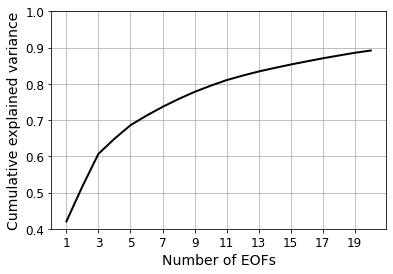

In [17]:
# make a plot of the cumulative explained variance as a function of the number of EOFs
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(np.arange(1, m+1), explained_variance[:m].cumsum(), 'k-', lw=2)
ax.set_xlabel("Number of EOFs", fontsize=14)
ax.set_ylabel("Cumulative explained variance", fontsize=14)
ax.set_xticks(np.arange(1, m+1, 2))
ax.set_yticks(np.arange(0.4, 1.1, 0.1))
ax.set_ylim(0.4, 1)
ax.tick_params(labelsize=12)
ax.grid()
plt.show()
fig.savefig("./report/figures/cumulative_explained_variance.png", dpi=300, bbox_inches='tight')

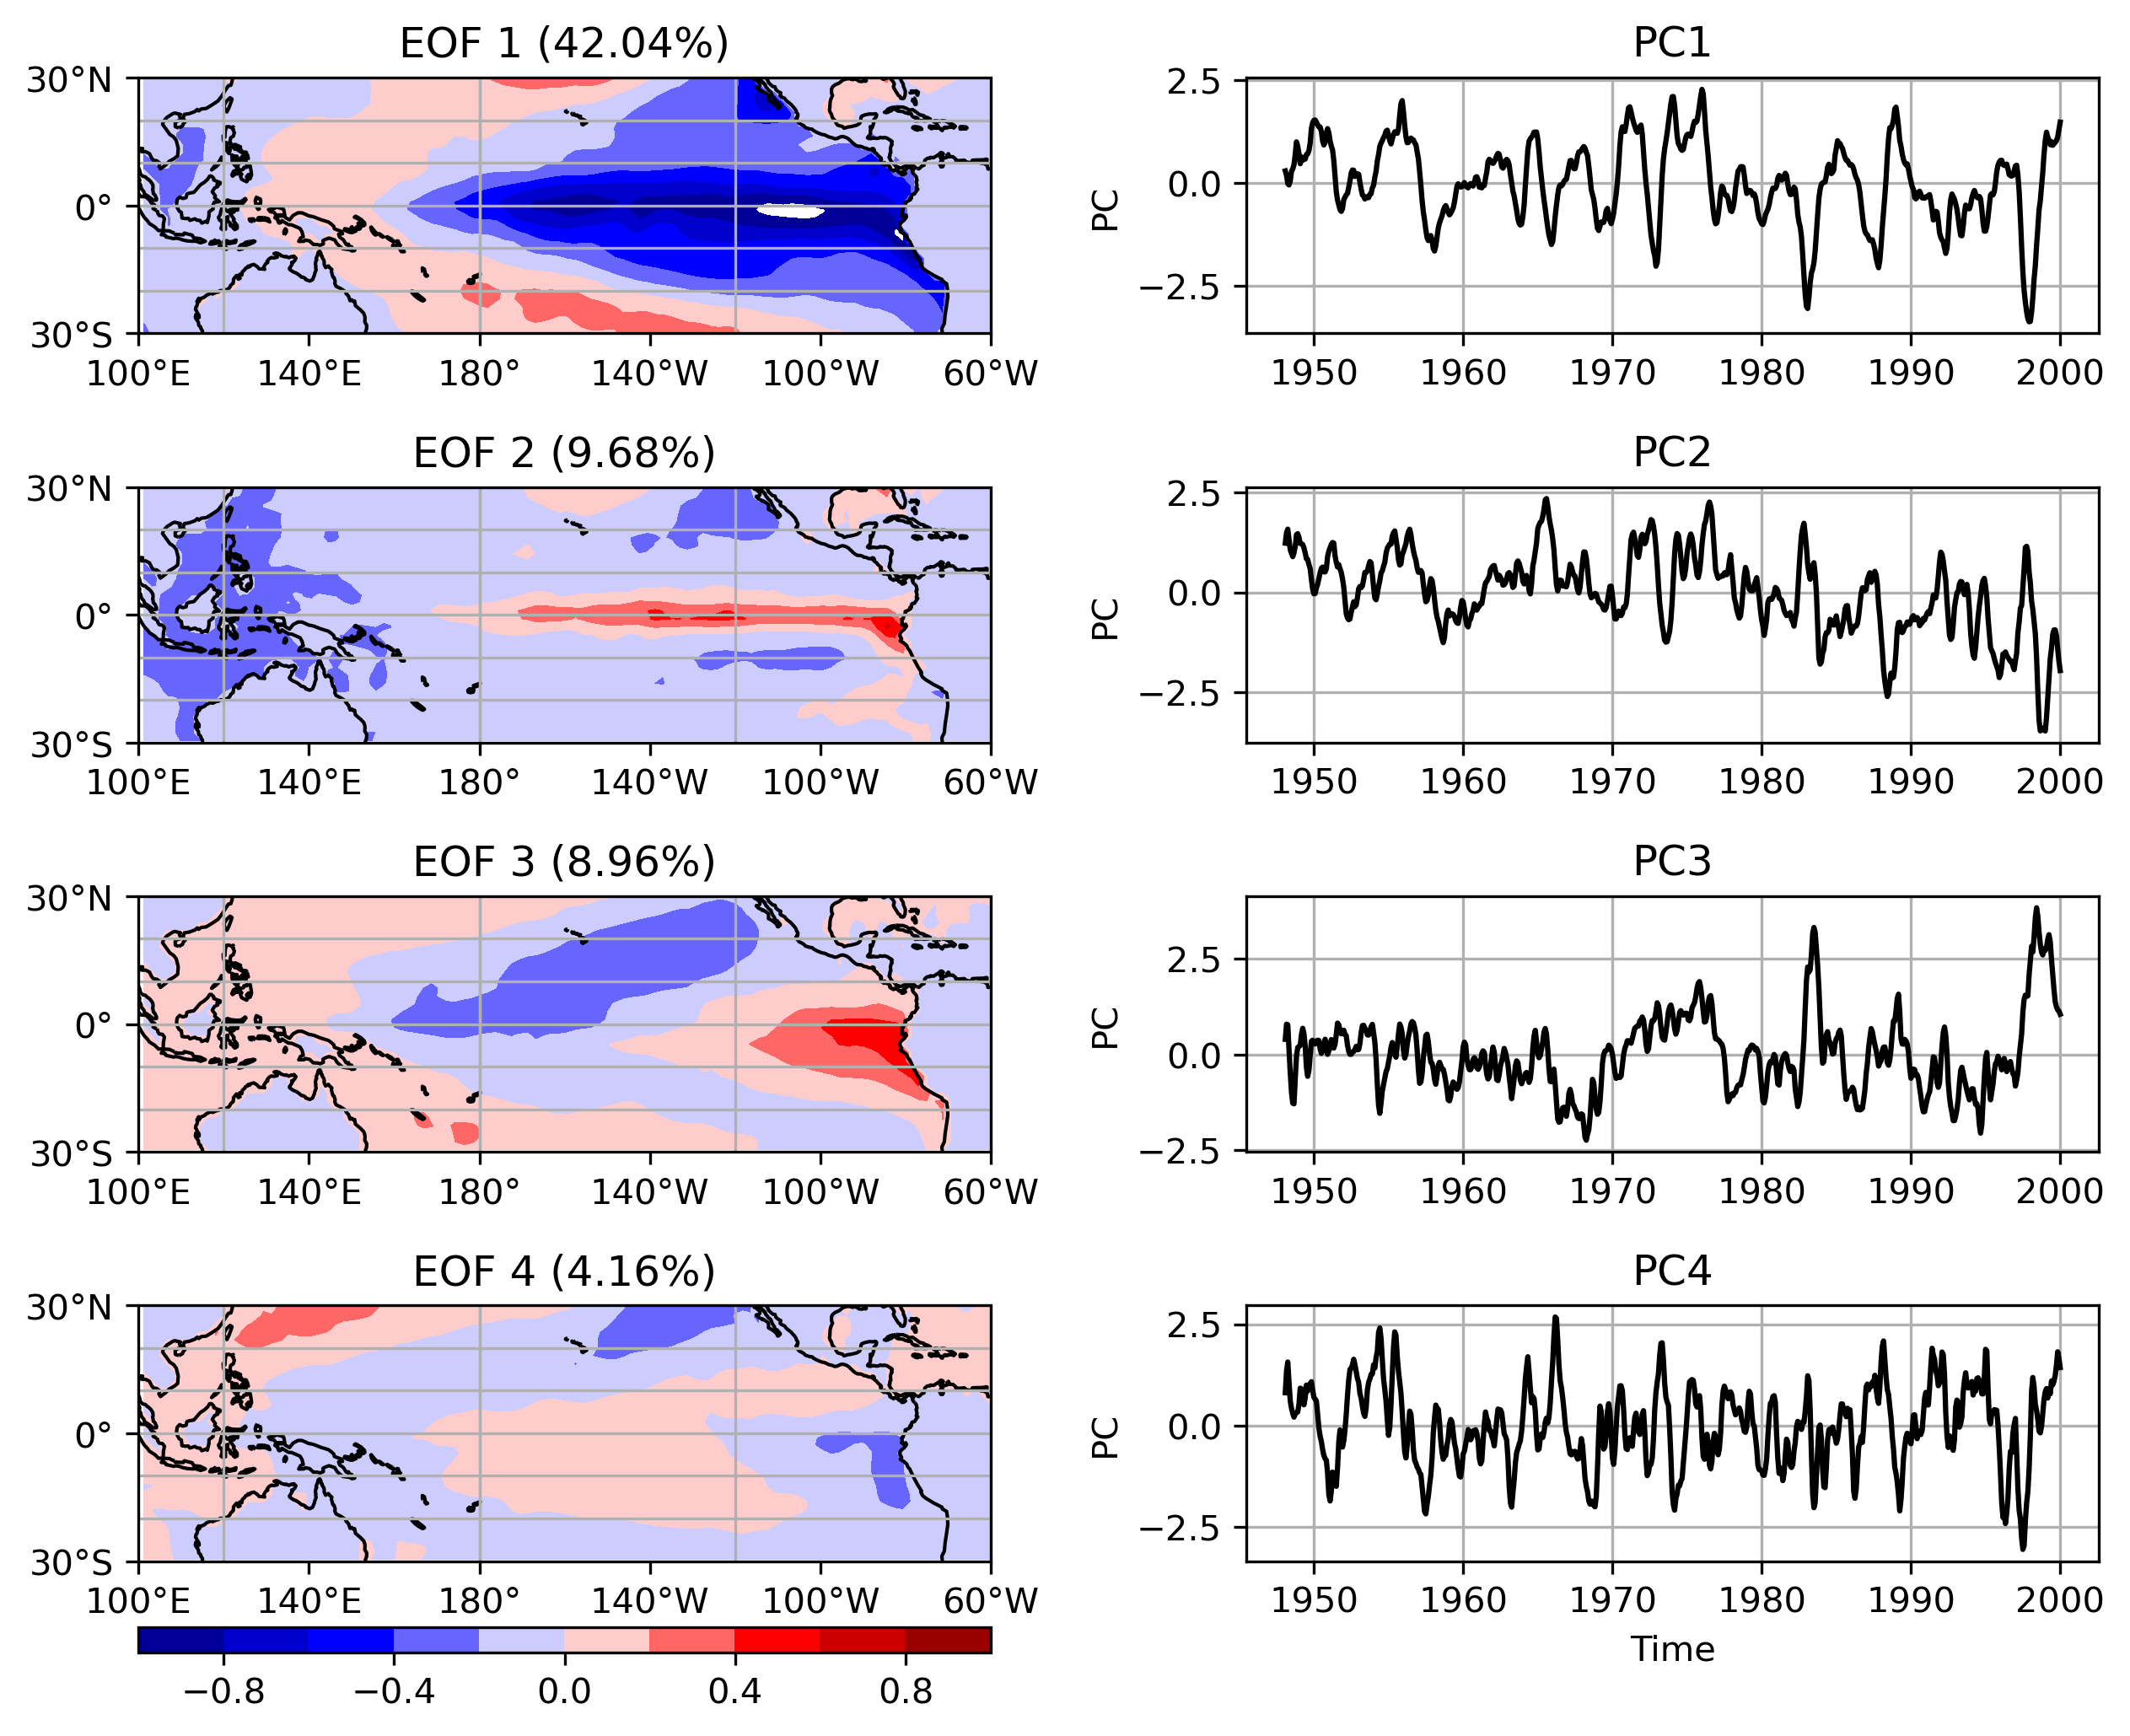

In [18]:
# plot the first 4 EOFs and PCs
# set up the figure, left column for EOFs, right column for PCs
plot_modes = 4
fig = plt.figure(figsize=(10, 10), dpi=300)
# set up the projection
projection = ccrs.PlateCarree(central_longitude=180)
# set up the axes
axes = np.empty((plot_modes, 2), dtype=object)
for i in range(plot_modes):
    axes[i,0] = fig.add_subplot(plot_modes, 2, 2*i+1, projection=projection)
    axes[i,1] = fig.add_subplot(plot_modes, 2, 2*i+2)
# cftime to float
time_fl = [t.year + t.month/12 for t in time]
# plot the first 4 EOFs
for i in range(plot_modes):
    ax = axes[i,0]
    # set extent
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    # plot the EOF
    im = ax.contourf(lon, lat, eofs[i,:,:], levels=np.linspace(-1, 1, 11), cmap=cmaps.BlWhRe, transform=ccrs.PlateCarree())
    # add coastlines
    ax.coastlines()
    # add gridlines
    ax.gridlines()
    # add title
    ax.set_title(f"EOF {i+1} ({explained_variance[i]*100:.2f}%)")
    # lat and lon ticks
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.set_xticks(np.arange(lon_min, lon_max+1, 40), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_min, lat_max+1, 30), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    # add colorbar
    if i == plot_modes - 1:
        cax = inset_axes(ax, width="100%", height="10%", loc='lower center', borderpad=-2.6)
        fig.colorbar(im, cax=cax, orientation='horizontal')
    aspect_ratio = 1/ax.get_data_ratio()
    # plot the PC
    ax = axes[i,1]
    # set aspect ratio
    ax.plot(time_fl, pcs[:,i], color='k')
    ax.set_title("PC" + str(i+1))
    if i == plot_modes-1:
        ax.set_xlabel("Time")
    ax.set_ylabel("PC")
    # add gridlines
    ax.grid()
    ax.set_aspect(60/200/ax.get_data_ratio())
# adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3, hspace=-0.4)
# show and save the figure
plt.show()
fig.savefig("./report/figures/EOFs_PCs.png", dpi=300, bbox_inches='tight')

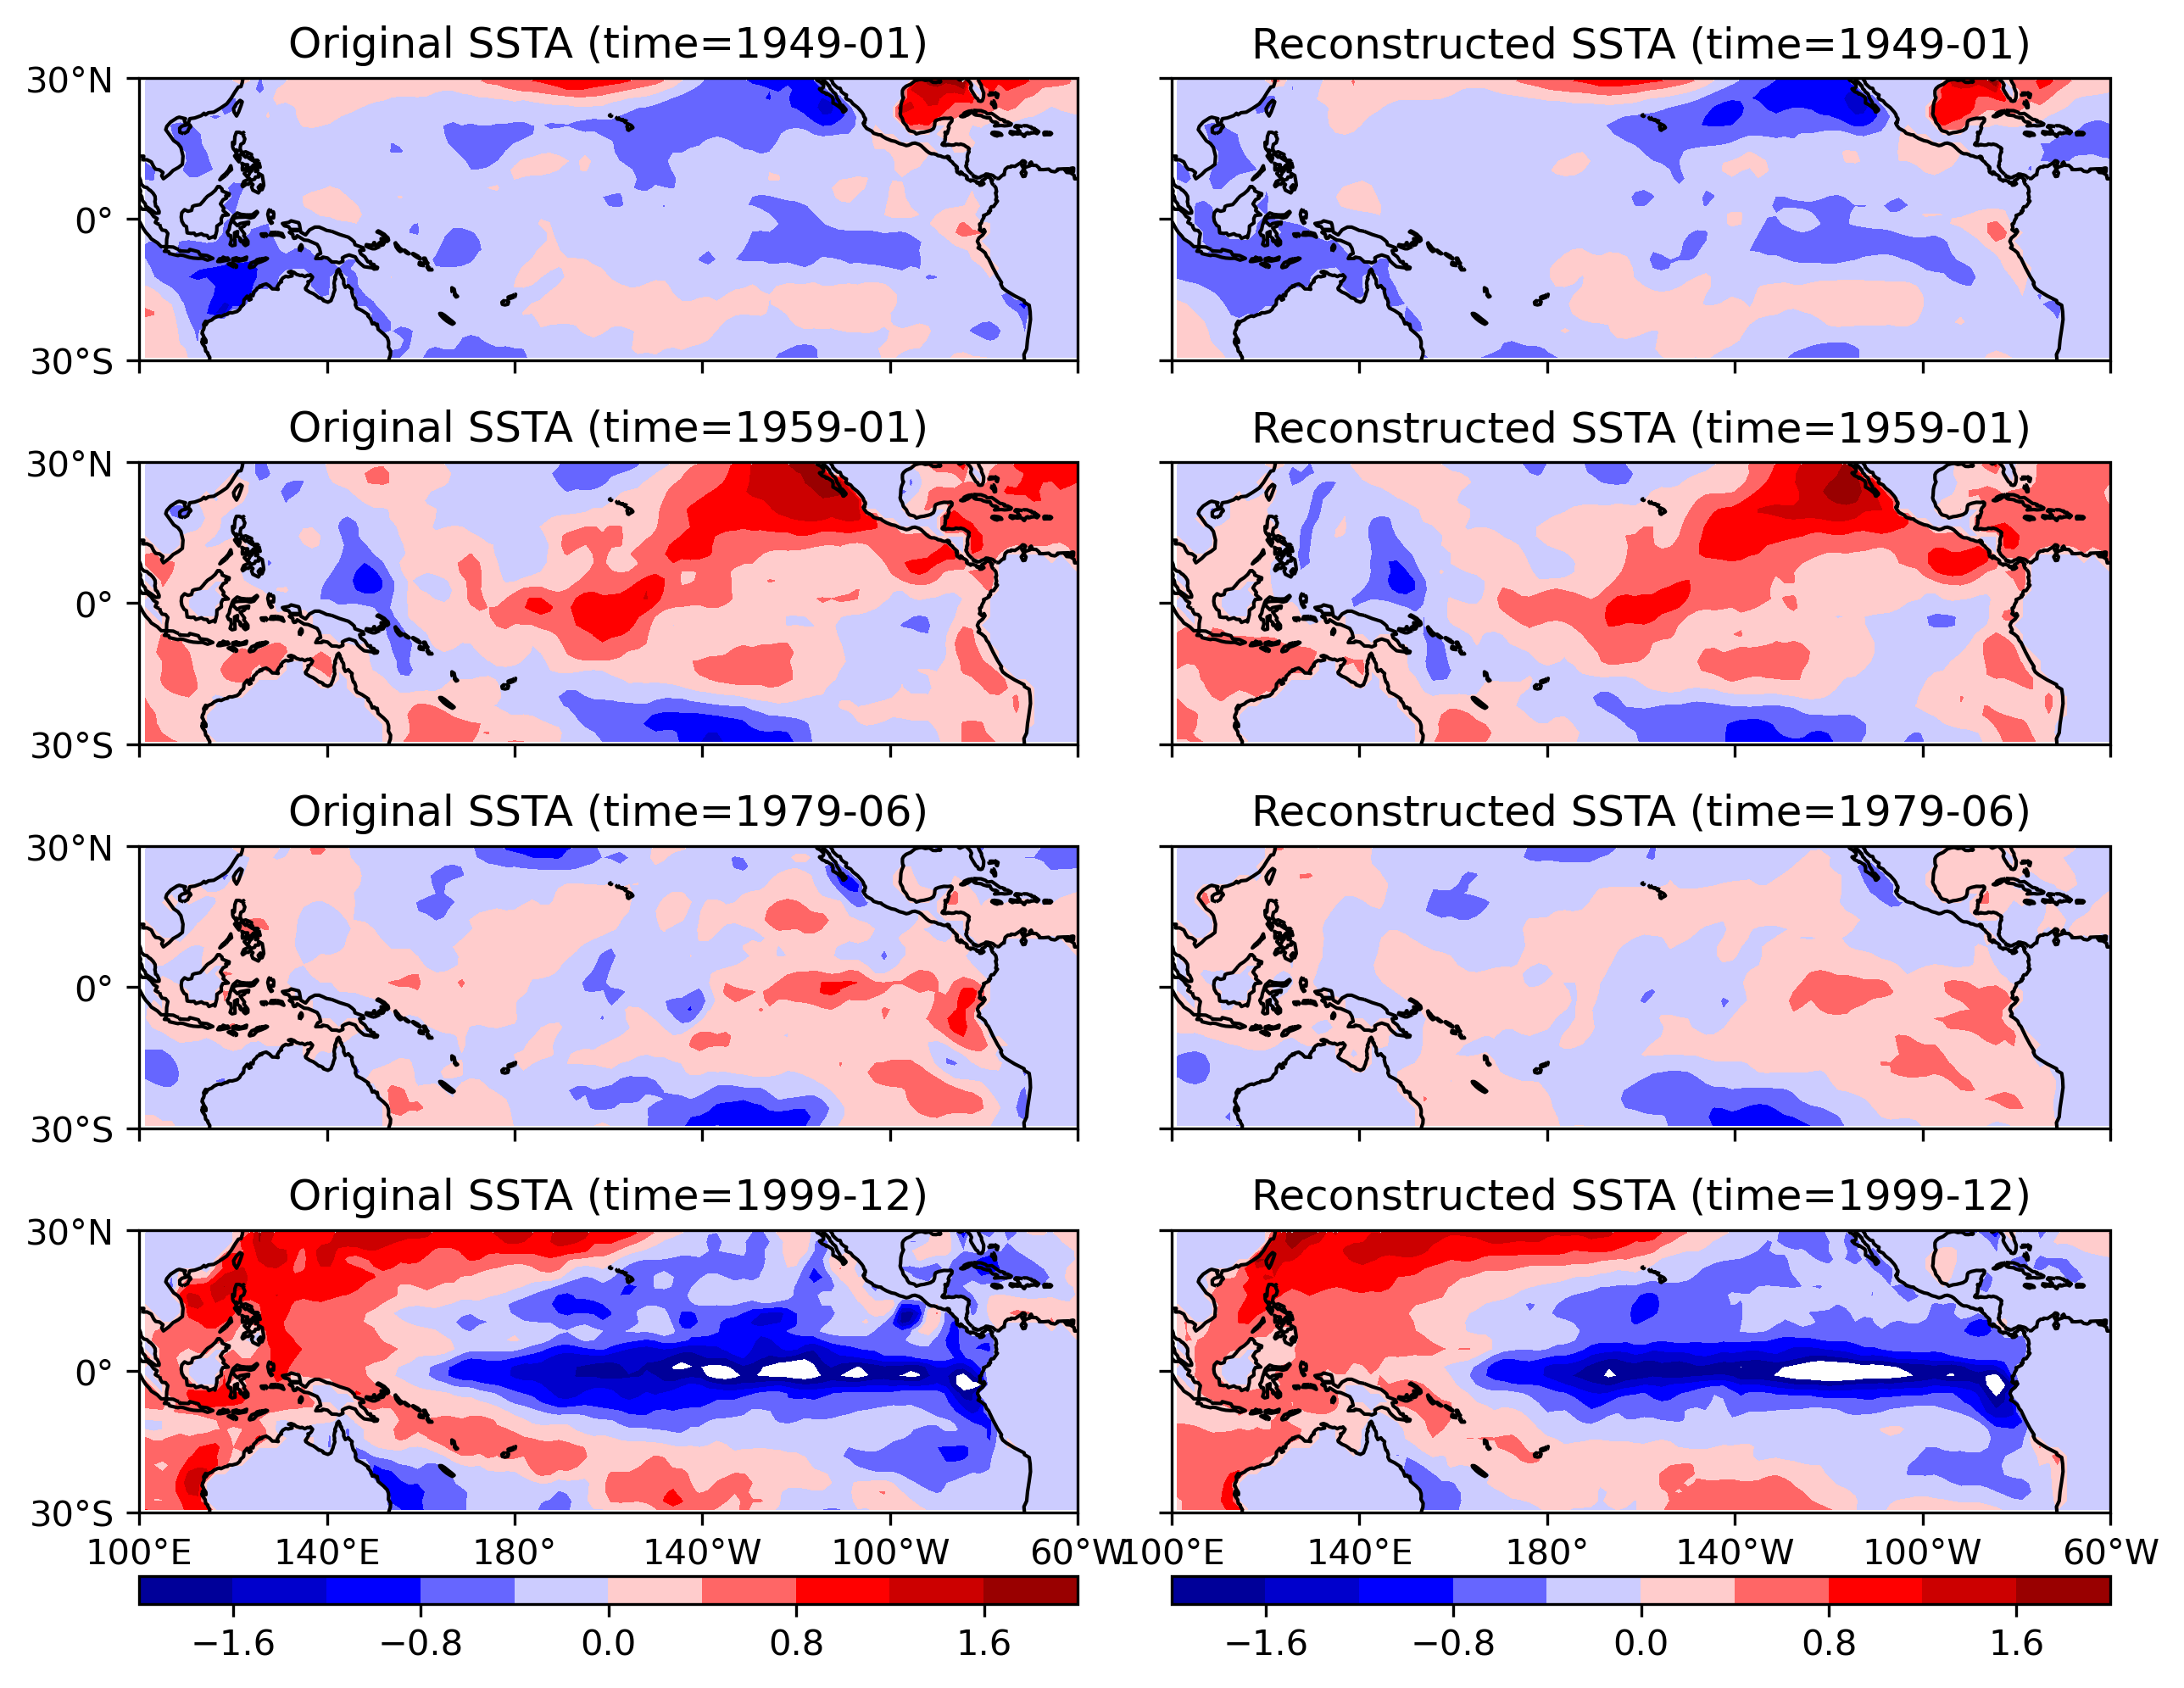

In [19]:
import cftime
# reconstruct the first m EOFs, can also use the solver.reconstructedField()
sst_recon = pcs[:, :m] @ (eofs[:m, :, :].reshape(m, -1))
sst_recon = sst_recon.reshape(-1, grid.shape[0], grid.shape[1])
# plot the original SST and the reconstructed SST at 4 time steps
plot_step = 4
time_steps = [cftime.DatetimeGregorian(1949, 1, 1, 0, 0, 0, 0),
                cftime.DatetimeGregorian(1959, 1, 1, 0, 0, 0, 0),
                cftime.DatetimeGregorian(1979, 6, 1, 0, 0, 0, 0),
                cftime.DatetimeGregorian(1999, 12, 1, 0, 0, 0, 0)]
# get time index
time_idx = [np.where(time == t)[0][0] for t in time_steps]
fig, axes = plt.subplots(plot_step, 2, figsize=(10, 10),
                            subplot_kw={'projection': projection},
                            dpi=300)
for i in range(plot_step):
    year, month = time_steps[i].year, time_steps[i].month
    for j in range(2):
        ax = axes[i,j]
        # set extent
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        if j == 0:
            im = ax.contourf(lon, lat, sst_anom[time_idx[i],:,:], levels=np.linspace(-2, 2, 11), cmap=cmaps.BlWhRe, transform=ccrs.PlateCarree())
            ax.set_title(f"Original SSTA (time={year}-{month:02d})")
        else:
            im = ax.contourf(lon, lat, sst_recon[time_idx[i],:,:], levels=np.linspace(-2, 2, 11), cmap=cmaps.BlWhRe, transform=ccrs.PlateCarree())
            ax.set_title(f"Reconstructed SSTA (time={year}-{month:02d})")
        # add coastlines
        ax.coastlines()
        # lat and lon ticks
        ax.set_xticks(np.arange(lon_min, lon_max+1, 40), crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_min, lat_max+1, 30), crs=ccrs.PlateCarree())
        if i == plot_step - 1:
            lon_formatter = LongitudeFormatter(zero_direction_label=True)
            ax.xaxis.set_major_formatter(lon_formatter)
        else:
            # add ticks but no labels
            ax.set_xticklabels([])
        if j == 0:
            lat_formatter = LatitudeFormatter()
            ax.yaxis.set_major_formatter(lat_formatter)
        else:
            # add ticks but no labels
            ax.set_yticklabels([])
        # add colorbar
        if i == plot_step - 1:
            cax = inset_axes(ax, width="100%", height="10%", loc='lower center', borderpad=-2.6)
            fig.colorbar(im, cax=cax, orientation='horizontal')
plt.subplots_adjust(wspace=0.1, hspace=-0.5)
plt.show()
fig.savefig("./report/figures/reconstruct_ssta.png", dpi=300, bbox_inches='tight')


### 3. Compute covariance and lag-covariance matrix in EOF space

* Compute covariance ($\hat{C}$) and lag-covariance matrix ($\hat{C}_{\Delta t}$) in EOF space, where $\Delta t$ is the time lag. $\hat{C} = \frac{1}{N} \sum_{t=1}^N P(t)P(t)^T$ and $\hat{C}_{\Delta t} = \frac{1}{N-\Delta t} \sum_{t=1}^{N-\Delta t} P(t)P(t+\Delta t)^T$.

In [29]:
# covariance of the first m PCs
PC_cov = pcs[:, :m].T @ pcs[:, :m] / (len(time))
print(PC_cov)
# lag-covariance of the first m PCs (lag=7)
lag = 7
PC_lag_cov = np.zeros((m, m))
for i in range(m):
    for j in range(m):
        PC_lag_cov[i,j] = np.mean(pcs[lag:, i] * pcs[:-lag, j])

# print the shapes of the matrices
print("Shape of the covariance matrix:", PC_cov.shape)
print("Shape of the lag-covariance matrix:", PC_lag_cov.shape)

[[ 9.98397350e-01  1.64294853e-08 -1.71936476e-09  2.82739983e-08
  -3.57484602e-08 -2.63635922e-08  1.62384453e-08 -3.58201007e-08
   8.59682370e-09  2.04413357e-08  6.49537801e-09  1.41369991e-08
  -2.67456746e-09  2.47397480e-08 -3.24768901e-09  5.74315573e-09
  -1.87219715e-08  2.10144591e-09 -1.91040535e-08  1.79578095e-08]
 [ 1.64294853e-08  9.98397648e-01  7.25953981e-08  5.34913491e-09
   7.04461955e-09 -1.52832424e-09  4.20289181e-09 -2.72232747e-09
   4.19811563e-08  1.06982698e-08 -5.73121595e-09 -1.45190802e-08
   3.43872948e-08  3.55335388e-08 -2.38800668e-09 -2.77008771e-09
  -5.57838327e-08 -2.02502957e-08 -6.72462690e-08 -2.98023224e-08]
 [-1.71936476e-09  7.25953981e-08  9.98397410e-01 -1.26086750e-08
  -3.20948104e-08  1.56653233e-08 -1.66205254e-08  7.92101815e-08
   2.39994655e-08 -4.67094097e-08 -1.35638771e-08 -6.18971328e-08
  -1.73846875e-08 -2.76053562e-08 -4.77601336e-09  2.71755152e-08
  -1.87219715e-08 -9.07442477e-09  3.17127267e-08 -1.47101202e-08]
 [ 2.82739983e-08  5.34913491e-09 -1.26086750e-08  9.98397827e-01
  -2.12532587e-08 -8.40578362e-09 -2.96112823e-09  3.48171376e-08
   4.27453184e-09  4.77601347e-10 -2.54083901e-08  2.29248642e-09
  -2.17786198e-08  1.17489929e-08 -3.56290570e-08  9.73112702e-09
   5.76942405e-08 -1.71936474e-08  5.34913491e-09  1.98682155e-08]
 [-3.57484602e-08  7.04461955e-09 -3.20948104e-08 -2.12532587e-08
   9.98397648e-01  4.60885285e-09 -6.59268906e-08 -1.35459670e-08
   1.54086131e-08 -1.84055615e-08 -1.23937545e-08 -4.27453184e-09
  -2.56471910e-08  1.94622540e-09  1.08534897e-08  9.12591691e-09
  -4.64467265e-09 -4.46199024e-08 -1.08415499e-08  1.86742124e-08]
 [-2.63635922e-08 -1.52832424e-09  1.56653233e-08 -8.40578362e-09
   4.60885285e-09  9.98397350e-01  6.78193857e-09  1.22265940e-08
   2.99456033e-08 -7.35506012e-09  2.63635922e-08 -5.27271844e-08
  -2.67456746e-09 -1.82443696e-08  4.29841185e-09  1.89846516e-09
   5.73121595e-09 -2.77008763e-08  2.63635922e-08  3.59156189e-08]
 [ 1.62384453e-08  4.20289181e-09 -1.66205254e-08 -2.96112823e-09
  -6.59268906e-08  6.78193857e-09  9.98397171e-01 -2.17308593e-09
   3.25365903e-08  4.10737133e-09 -3.14261683e-08 -1.91040539e-09
  -3.39096928e-08 -1.95100132e-08  3.46977345e-08 -6.26851737e-10
  -2.29248642e-09 -2.36412649e-08  1.49011612e-08 -1.06027489e-08]
 [-3.58201007e-08 -2.72232747e-09  7.92101815e-08  3.48171376e-08
  -1.35459670e-08  1.22265940e-08 -2.17308593e-09  9.98397410e-01
   1.83876505e-08  1.21788339e-08 -4.27930793e-08  1.94861336e-08
   2.00114947e-08  1.35877576e-08  2.50263099e-08  2.46084078e-08
   4.25065183e-09 -1.10325908e-08  8.52995967e-08  1.21310739e-08]
 [ 8.59682370e-09  4.19811563e-08  2.39994655e-08  4.27453184e-09
   1.54086131e-08  2.99456033e-08  3.25365903e-08  1.83876505e-08
   9.98397708e-01  1.93786729e-08  1.25847945e-08  2.85605584e-08
  -1.57608437e-09 -2.44770670e-09  1.82682509e-08  2.00443306e-09
  -2.65785136e-08 -2.39039455e-08  2.17308593e-09  1.92712140e-08]
 [ 2.04413357e-08  1.06982698e-08 -4.67094097e-08  4.77601347e-10
  -1.84055615e-08 -7.35506012e-09  4.10737133e-09  1.21788339e-08
   1.93786729e-08  9.98397410e-01  7.16401960e-09 -3.11396064e-08
  -1.20355530e-08  1.40414791e-08  1.55220423e-08  1.71100680e-08
  -7.64162122e-10  2.91336804e-08 -1.60474052e-08 -4.56586875e-08]
 [ 6.49537801e-09 -5.73121595e-09 -1.35638771e-08 -2.54083901e-08
  -1.23937545e-08  2.63635922e-08 -3.14261683e-08 -4.27930793e-08
   1.25847945e-08  7.16401960e-09  9.98397410e-01  2.13965397e-08
   3.43872948e-08  1.81488502e-09  2.46442280e-08 -3.05664849e-09
  -3.68708228e-08  3.17127267e-08  1.73846875e-08  1.91040535e-08]
 [ 1.41369991e-08 -1.45190802e-08 -6.18971328e-08  2.29248642e-09
  -4.27453184e-09 -5.27271844e-08 -1.91040539e-09  1.94861336e-08
   2.85605584e-08 -3.11396064e-08  2.13965397e-08  9.98396754e-01
  -9.16994569e-09 -6.68641853e-09 -2.10144591e-09 -1.37549181e-08
   3.05664862e-08 -3.61066590e-08 -3.05664849e-09 -6.87745905e-09]
 [-2.67456746e-09  3.4387294

Shape of the covariance matrix:
(20, 20)

Shape of the lag-covariance matrix:
(20, 20)

### 4. Compute propagator matrix

* Compute propagator matrix: ($\hat{G}$) = $\hat{C}_{\Delta t}\hat{C}^{-1}$ in EOF space.

In [30]:
# Propagator matrix: G = PC_lag_cov @ inv(PC_cov)
G = PC_lag_cov @ np.linalg.inv(PC_cov)
# print the shape of the propagator matrix
print(G)
print("Shape of the propagator matrix:", G.shape)

[[ 0.48637918 -0.08129336  0.19975406  0.33011545  0.19613411 -0.09225613
  -0.21855115 -0.23009576 -0.07656635  0.10973685 -0.10018457  0.10447843
  -0.0191879   0.09549717  0.05893229 -0.01367727  0.01162189 -0.06873651
   0.02071213 -0.01971424]
 [ 0.52435042  0.51566444 -0.16183966  0.03198382  0.01076359 -0.04851098
   0.06723695  0.16314991  0.01725997 -0.15285553  0.06834981  0.02637668
   0.05014419 -0.15243999 -0.07807543  0.10131509  0.0306077   0.04070807
   0.02261329 -0.07791736]
 [-0.03141359  0.00493653  0.59773589 -0.03969554  0.0346486   0.01790795
   0.09170832  0.07090399 -0.07954979  0.04604743  0.00566078  0.06009943
  -0.02728807 -0.04323848 -0.0704152   0.16081126 -0.07385236  0.01202952
   0.04861098 -0.09965485]
 [-0.28282966  0.15098904  0.05959726  0.2370476   0.09724934  0.26940371
   0.10861242 -0.0335556   0.04458612 -0.20168704  0.02540626 -0.00474901
   0.165301    0.04002014  0.11745248 -0.083128    0.05814207 -0.06174415
   0.08504403 -0.06563855]
 [ 0.04260899 -0.00484569 -0.0344802  -0.19101015  0.48698965 -0.14397292
  -0.06757297  0.15639693  0.23335043 -0.11939994 -0.02435366  0.16042106
  -0.05893325 -0.15321516 -0.0201571  -0.01839806  0.06138413  0.02430871
  -0.05949342  0.03829366]
 [ 0.0704089  -0.28469065  0.06099292  0.11610341 -0.30133748  0.1625273
   0.00240205 -0.05603389 -0.03951802 -0.14137598  0.06959588  0.18072642
  -0.01304203 -0.17138093  0.15197737 -0.16211835  0.14645005  0.25446025
  -0.0614425   0.02660036]
 [ 0.22027952 -0.14544943 -0.02645225  0.05496467 -0.11182601  0.06664488
   0.48230403  0.08920812 -0.08104842  0.1930074   0.06525549 -0.03543235
   0.05049955 -0.0961167  -0.04435774 -0.20958368 -0.11090814 -0.07862207
   0.07862578  0.17853976]
 [ 0.12510953 -0.02177113 -0.01106013 -0.05375092  0.17832592 -0.10879569
   0.08632054  0.0814272  -0.04045152  0.10866807  0.02441735 -0.11257365
   0.20710889  0.08796754  0.11866813  0.03914799  0.03426616  0.04928362
   0.03902578 -0.01713655]
 [-0.15483612  0.11023556 -0.02398499  0.14968883 -0.00670837 -0.26044311
  -0.06839723 -0.02055505 -0.17434441 -0.10388077  0.09036268 -0.24594075
  -0.03113476 -0.12325546 -0.07337669 -0.00662547 -0.06268438  0.05611628
   0.07993864  0.10239688]
 [ 0.02030368 -0.09070337 -0.11995041 -0.03707136 -0.00116784  0.05401955
   0.05080945  0.00217559 -0.19160512  0.31488646  0.08846784  0.0728223
   0.12458294 -0.08753857  0.15323107  0.20702145  0.01480494  0.03597428
   0.11635395 -0.11057636]
 [ 0.00106115  0.13617216 -0.01737586  0.03879639 -0.16002222 -0.11980637
   0.05916216 -0.15528452 -0.02754017  0.08164472  0.20215232  0.12662846
  -0.03402248  0.02405215  0.09317464 -0.00378083 -0.12965043 -0.09706102
   0.09358432 -0.03204114]
 [-0.21061489  0.26680744  0.12928485  0.0509228   0.07145483  0.03036868
  -0.00622937  0.01431031 -0.11517546  0.05132536  0.04306245  0.33712504
  -0.02797472 -0.03146394  0.10094316 -0.16356055 -0.04590609  0.18392057
  -0.08690191 -0.05032427]
 [ 0.05691323  0.07962836 -0.00114111 -0.05614496 -0.07970938 -0.11043705
   0.02898062 -0.01737315  0.19639178  0.03548388  0.08648799 -0.10134655
   0.14573235  0.12290611  0.28654135  0.01679235 -0.14024114  0.14960684
  -0.00662861 -0.00279249]
 [ 0.07466774  0.02952037  0.20750386 -0.16140833 -0.18035027 -0.06704337
   0.0397796  -0.03474792 -0.03307461 -0.11308299  0.00432157 -0.04302476
  -0.01737593  0.23028935  0.0762324  -0.01280713  0.04631291  0.01693021
   0.00724396 -0.09111304]
 [-0.10635543  0.00736465  0.02725873  0.0022212  -0.0010805   0.18091372
  -0.01667018  0.07132719  0.04289847  0.14139924  0.16413508  0.03172247
   0.09355294  0.02643975 -0.00578188  0.06119996 -0.06131113 -0.01538409
  -0.0508088  -0.07044115]
 [ 0.03282367  0.01393443  0.05812838  0.02272593 -0.03152059 -0.07287763
  -0.09938292 -0.0348037   0.26123717  0.10597051 -0.01945466 -0.00275832
  -0.08416824  0.03407383 -0.10302851  0.15169426  0.08556612  0.02783692
   0.11488034 -0.10150573]
 [-0.12992503  0.0

Shape of the propagator matrix:
(20, 20)

### 5. Regress initial SSTA onto EOF space

* Take an initial SSTA state vector $T$ at any $t_0$, regress $T(t_0)$ onto $E_i$ to determine
$P_i(t_0)$ and then form $P(t_0)$.

In [31]:
T_t0 = sst_test_anom[0,:,:].flatten()
# determine PCs at time t0
pcs_t0 = []
for i in range(m):
    eof_i = eofs[i,:,:].flatten()
    # linear regression
    coef, intercept = np.polyfit(eof_i, T_t0, 1)
    pcs_t0.append(coef)
pcs_t0 = np.array(pcs_t0)
print("Values of leading PCs at time t0:", pcs_t0)

Values of leading PCs at time t0: [ 1.49582672 -1.90936002  1.0234742  -0.60880677 
-0.60014367  2.50000711
 -0.70739019  2.0024741  -0.19612283 -0.11541311  0.73771769 -0.71804966
 -1.89587164 -0.87269602 -0.67096618  0.9768891  -2.33495328  0.5182931
 -0.58000372  0.12161947]

### Make SST forecast in EOF space
* Make SST forecast in EOF space from $t_0$ to $t_n$: $P(t_n) = G^{\frac{t_n-t_0}{\Delta t}}P(t_0)$;


In [32]:
# make forecast for 9 months
forecast_months = 9
# initialize the forecast array
pcs_tn = np.zeros((forecast_months, m))
print(pcs_t0.shape)
for i in range(forecast_months):
    pcs_tn[i,:] = G ** ((i+1)/7) @ pcs_t0
print("Values of leading PCs at time tn:", pcs_tn)
print("Shape of the forecast leading PCs:", pcs_tn.shape)

(20,)

<ipython-input-32-aa857fb360a7>:7: RuntimeWarning: invalid value encountered in power
  pcs_tn[i,:] = G ** ((i+1)/7) @ pcs_t0


Values of leading PCs at time tn: [[        nan         nan         nan         nan         
nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan]
 [-0.09190087 -0.0718541   1.08408555 -1.02026659 -0.15294515  0.8022839
   0.69255483 -0.52264961 -0.55729457  0.06450211 -0.63037072 -0.75091424
  -0.37437928 -0.08384495  0.55384103 -0.08754335 -0.57276452  0.60465576
  -0.19005899  0.44082065]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan]]

Shape of the forecast leading PCs:
(9, 20)

### Transform the forecast in EOF space

* Transform the forecast in EOF space, $P(t_n)$, back to the physical space: $T(t_n)=\sum _{i=1}^M P(t_n) E_i$.

In [33]:
# transform the forecasted PCs to SSTA
sst_forecast = np.sum(pcs_tn[:, :, np.newaxis, np.newaxis] * eofs[:m, :, :], axis=1)
print("Shape of the forecasted SSTA:", sst_forecast.shape)

Shape of the forecasted SSTA:
(9, 32, 107)

### Plot the forecast SSTA
* Plot the forecast SSTA from 2000-02 to 2009-10 and compare it with the observed SSTA.

All data are nan for time 2000-02

<ipython-input-34-a5ae108d59e3>:23: RuntimeWarning: All-NaN slice encountered
  min_sst = np.nanmin(plot_sst)
<ipython-input-34-a5ae108d59e3>:24: RuntimeWarning: All-NaN slice encountered
  max_sst = np.nanmax(plot_sst)
c:\Users\liujj\miniconda3\envs\TC\lib\site-packages\matplotlib\contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
c:\Users\liujj\miniconda3\envs\TC\lib\site-packages\matplotlib\contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


All data are nan for time 2000-03

All data are nan for time 2000-04

All data are nan for time 2000-05

All data are nan for time 2000-06

All data are nan for time 2000-07

All data are nan for time 2000-09

All data are nan for time 2000-10

ValueError: Axis limits cannot be NaN or Inf

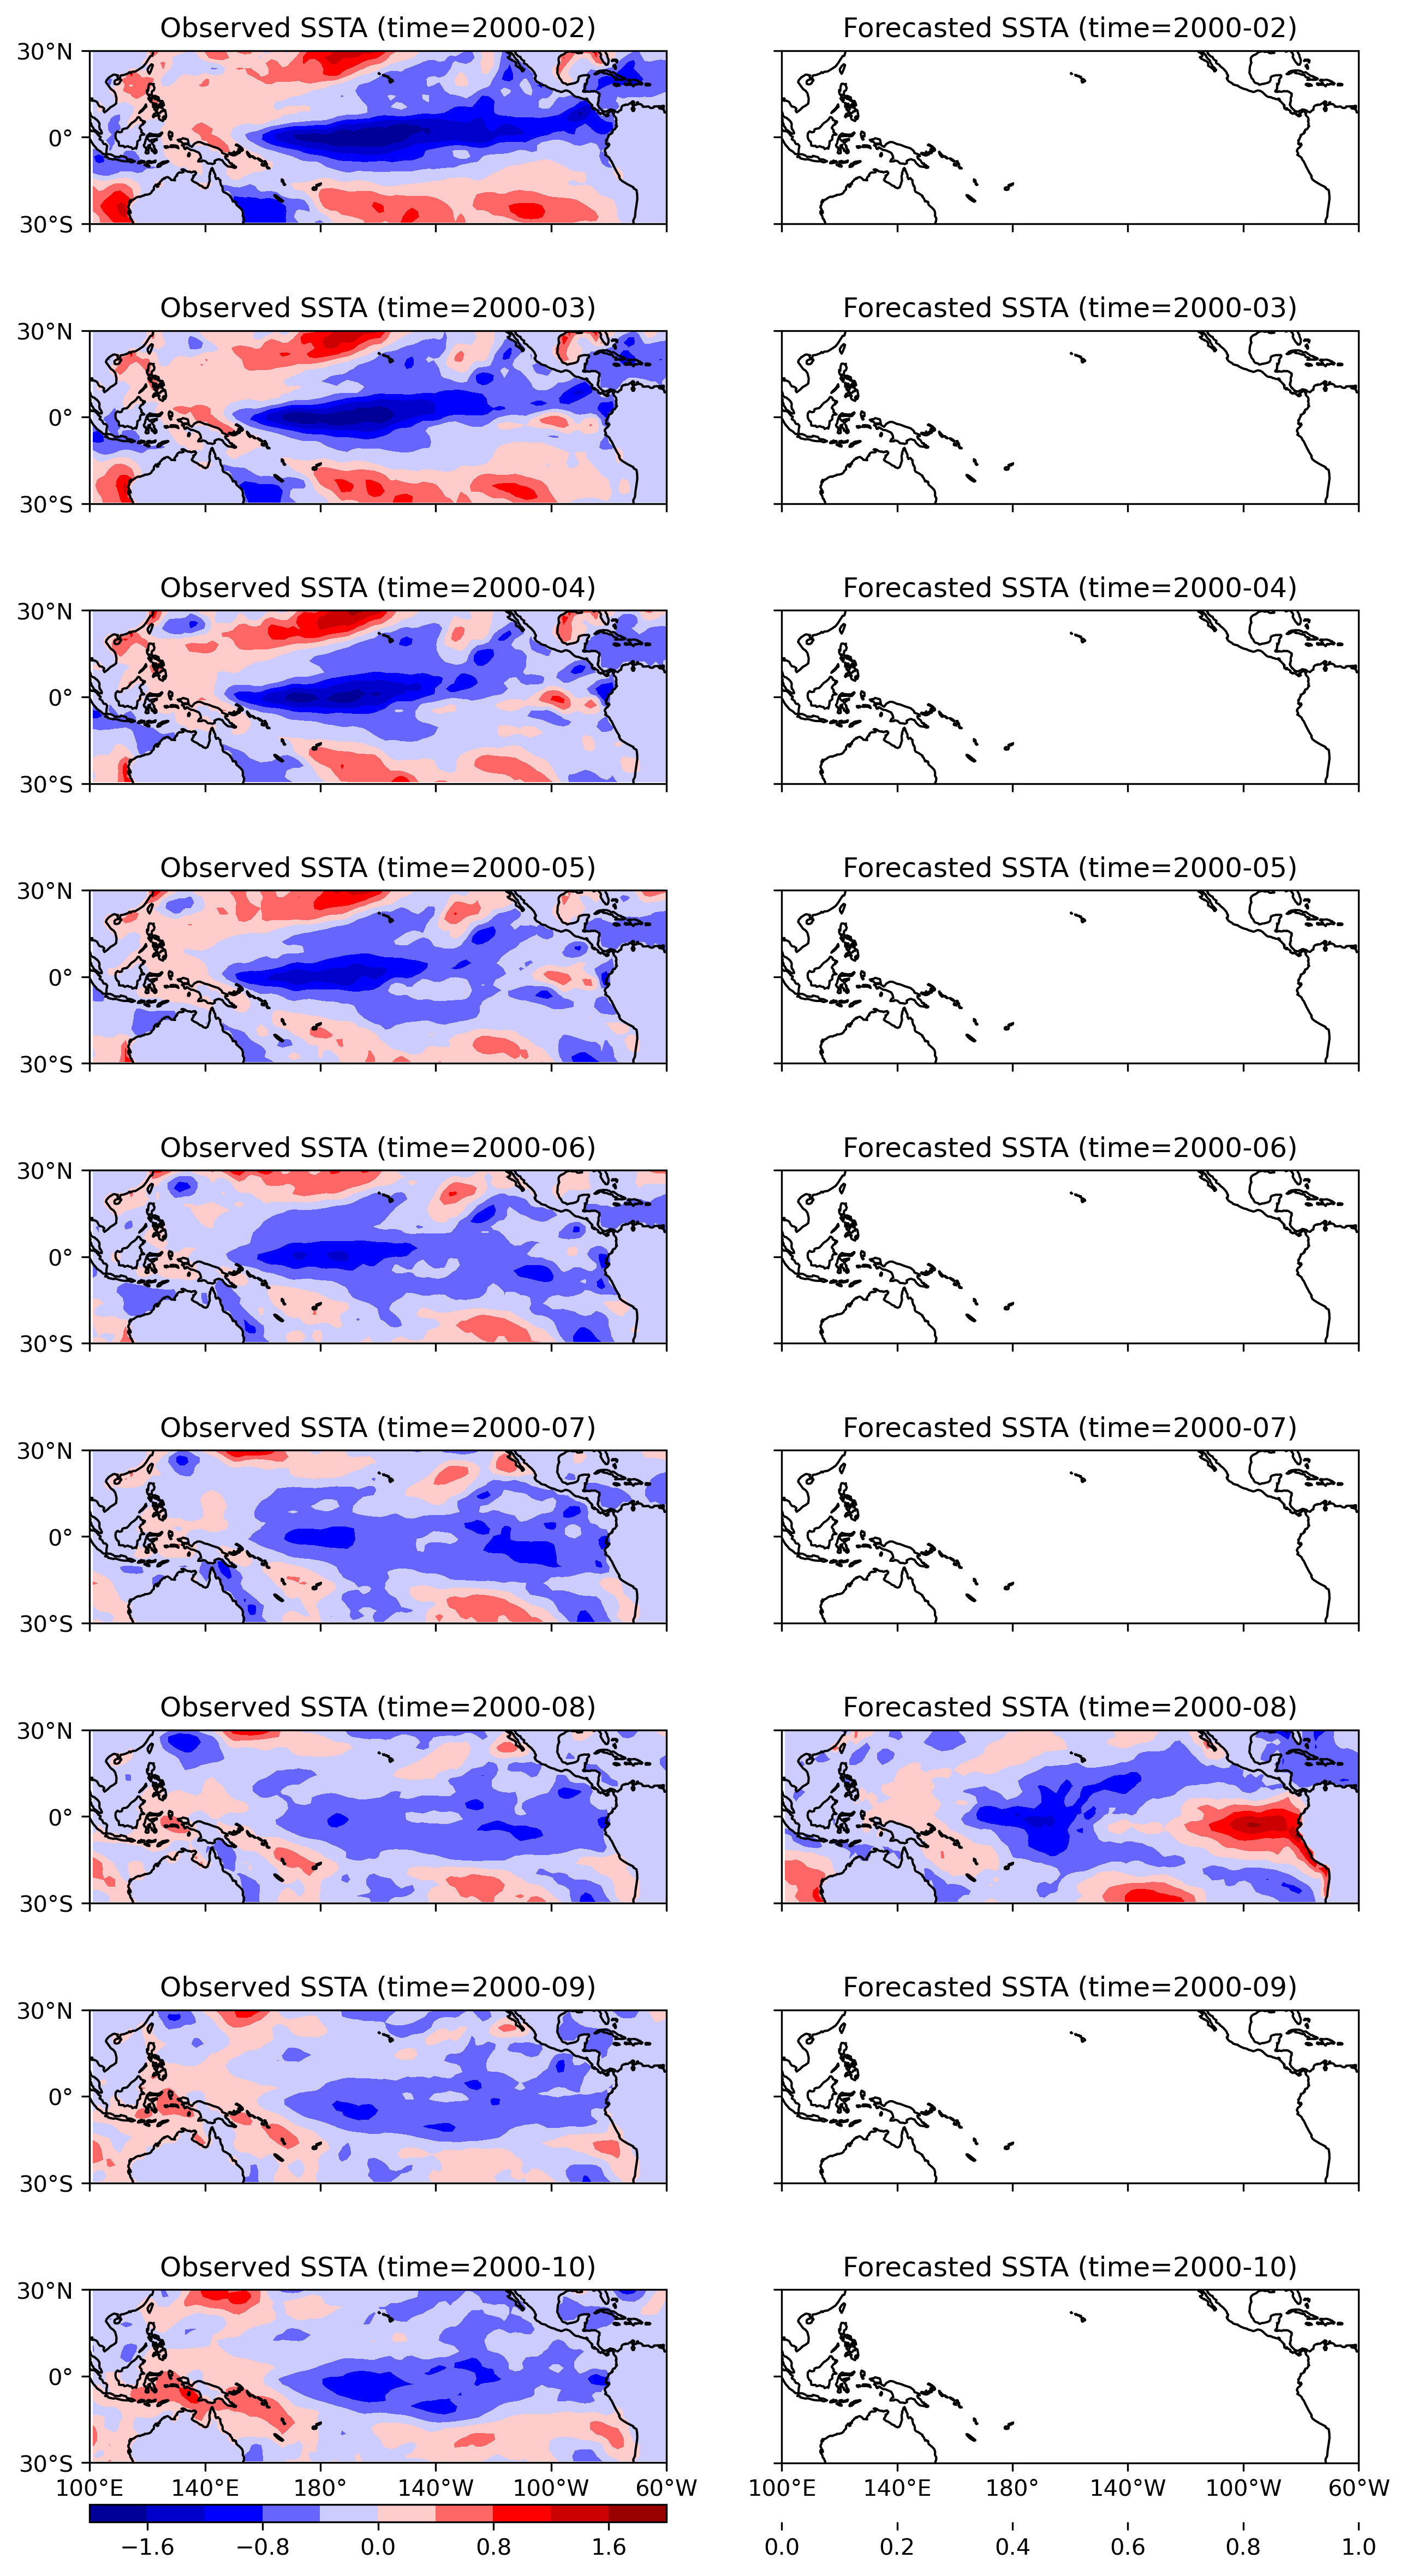

In [34]:
forecast_times = xr.cftime_range(start=cftime.DatetimeGregorian(2000, 2, 1, 0, 0, 0, 0), 
                            periods=forecast_months, freq='MS')
# plot the forecasted SSTA
projection = ccrs.PlateCarree(central_longitude=180)
fig, axes = plt.subplots(forecast_months, 2, figsize=(10, 20),
                            subplot_kw={'projection': projection},
                            dpi=300)
for i in range(forecast_months):
    year, month = forecast_times[i].year, forecast_times[i].month
    for j in range(2):
        ax = axes[i,j]
        # set extent
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        if j == 0:
            im = ax.contourf(lon, lat, sst_test_anom[i+1,:,:], levels=np.linspace(-2, 2, 11), 
                            cmap=cmaps.BlWhRe, transform=ccrs.PlateCarree())
            ax.set_title(f"Observed SSTA (time={year}-{month:02d})")
        else:
            plot_sst = sst_forecast[i,:,:]
            # check if all data are nan
            if np.all(np.isnan(plot_sst)):
                print(f"All data are nan for time {year}-{month:02d}")
            min_sst = np.nanmin(plot_sst)
            max_sst = np.nanmax(plot_sst)
            im = ax.contourf(lon, lat, plot_sst, levels=np.linspace(min_sst, max_sst, 11),
                            cmap=cmaps.BlWhRe, transform=ccrs.PlateCarree())
            ax.set_title(f"Forecasted SSTA (time={year}-{month:02d})")
        # add coastlines
        ax.coastlines()
        # lat and lon ticks
        ax.set_xticks(np.arange(lon_min, lon_max+1, 40), crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_min, lat_max+1, 30), crs=ccrs.PlateCarree())
        if i == forecast_months - 1:
            lon_formatter = LongitudeFormatter(zero_direction_label=True)
            ax.xaxis.set_major_formatter(lon_formatter)
        else:
            # add ticks but no labels
            ax.set_xticklabels([])
        if j == 0:
            lat_formatter = LatitudeFormatter()
            ax.yaxis.set_major_formatter(lat_formatter)
        else:
            # add ticks but no labels
            ax.set_yticklabels([])
        # add colorbar
        if i == forecast_months - 1:
            cax = inset_axes(ax, width="100%", height="10%", loc='lower center', borderpad=-2.6)
            fig.colorbar(im, cax=cax, orientation='horizontal')
plt.subplots_adjust(wspace=0.1, hspace=-0.5)
plt.show()
fig.savefig("./report/figures/forecast_ssta.png", dpi=300, bbox_inches='tight')